In [31]:

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from tensorflow import keras
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")
     


In [33]:

Macophieu = "AMZN" #@param ["GOOG", "AMZN", "FB","AAPL","TSLA"]

prop = 'Close'  #@param ["Open", "High", "Low","Close","Volume"]

companyName = 'Amazon' #@param["Google", "Amazon", "Facebook", "Apple", "Tesla"]

# Chọn cổ phiếu cần dự doán
tickerData = yf.Ticker(Macophieu) 
#@title Date fields
start ='2010-11-10'#@param {type:"date"}
end ='2025-3-10'#@param {type:"date"}
tickerDf = tickerData.history(period='1d', start=start, end=end)
#lấy giá trị từ ngày đến những ngày trước đó
data = tickerDf
data.reset_index(inplace=True)
# đánh số thứ tự lại cho data thay cho cột ngày
print(data)

                          Date        Open        High         Low  \
0    2010-11-10 00:00:00-05:00    8.529500    8.668500    8.470500   
1    2010-11-11 00:00:00-05:00    8.550000    8.602500    8.471000   
2    2010-11-12 00:00:00-05:00    8.506000    8.563000    8.252500   
3    2010-11-15 00:00:00-05:00    8.258000    8.267500    7.928000   
4    2010-11-16 00:00:00-05:00    7.937000    8.045500    7.838500   
...                        ...         ...         ...         ...   
3597 2025-03-03 00:00:00-05:00  213.350006  214.009995  202.550003   
3598 2025-03-04 00:00:00-05:00  200.110001  206.800003  197.429993   
3599 2025-03-05 00:00:00-05:00  204.800003  209.979996  203.259995   
3600 2025-03-06 00:00:00-05:00  204.399994  205.770004  198.300003   
3601 2025-03-07 00:00:00-05:00  199.490005  202.270004  192.529999   

           Close     Volume  Dividends  Stock Splits  
0       8.666500  108806000        0.0           0.0  
1       8.518500  113834000        0.0           

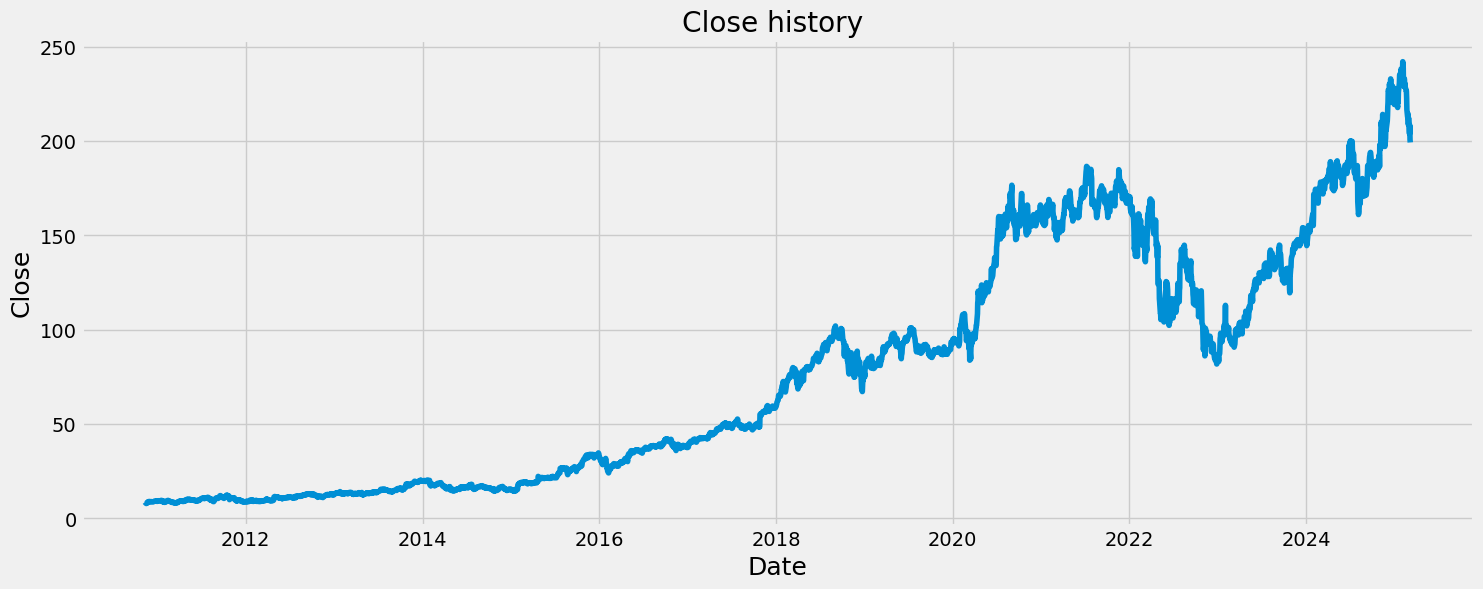

In [35]:
plt.figure(figsize = (16,6))
plt.plot(data['Date'],data[prop])
plt.title( prop + " history ")
plt.xlabel('Date', fontsize = 18)
plt.ylabel(f'{prop}', fontsize = 18)
plt.show()

In [37]:

data_end = int(np.floor(0.8*(data.shape[0])))
train = data[0:data_end][prop] 
test = data[data_end:][prop]
date_test = data[data_end:]['Date']

     


In [39]:
train = train.values.reshape(-1)
test = test.values.reshape(-1)
date_test = date_test.values.reshape(-1)

In [41]:
def get_data(train,test,time_step,num_predict,date):
  x_train= list()
  y_train = list()
  x_test = list()
  y_test = list()
  date_test= list()
# khởi tọa các list trổng để lưu data test, train
# time_step = 30 số lượng ngày đưa vào, num_predict = 1 số lượng đầu ra
  for i in range(0,len(train) - time_step - num_predict):
    x_train.append(train[i:i+time_step])
    y_train.append(train[i+time_step:i+time_step+num_predict])
# y(dự đoán của 30 đầu vào) = f(x(giá open 30 ngày)w(giá trị cần cải thiện trong model) + bias(giá trị cần cải thiện trong model))
# đưa vào giá của 30 ngày tương ứng với 1 state và đầu ra y mũ cho 1 node tưởng tự n data còn lại
# đưa giá trị vào mảng x_train(giá mở của 80% tập data ngày trước để đưa vào cho máy học), y_train(giá mở của ngày thứ 31) 
  for i in range(0, len(test) - time_step - num_predict):
    x_test.append(test[i:i+time_step])
    y_test.append(test[i+time_step:i+time_step+num_predict])
    date_test.append(date[i+time_step:i+time_step+num_predict])
# Xử lý đưa data vào list tương tự như tập train
  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test), np.asarray(date_test)
  # chuyển dữ liệu thành dạng mảng

In [43]:

# gọi hàm dựa data vào mảng train test time_step num_predict, date_test
x_train, y_train, x_test, y_test, date_test = get_data(train,test,30,1, date_test)

# chuyển về dạng ma trận đưa vào minmaxscaler()
x_train = x_train.reshape(-1,30)
x_test = x_test.reshape(-1,30)

# dua ve 0->1 cho tap train
scaler = MinMaxScaler()

# gọi hàm scaler để nén hoặc giải nén data về khoảng (0,1) để máy hiểu góp phần tăng tốc độ máy học
# fit_transform nén data lại cho model cho 4 ma trận x, y_train x,y test
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)
     


In [45]:
# chuyển về dạng ma trận đưa vào keras() thêm một chiều thứ 3 để có bias => để thành ma trận 3D cho phù hợp với bài toán

# Reshape lai cho x_train
x_train = x_train.reshape(-1,30,1)
y_train = y_train.reshape(-1,1)

#reshape lai cho test
x_test = x_test.reshape(-1,30,1)
y_test = y_test.reshape(-1,1)
date_test = date_test.reshape(-1,1)
     


In [47]:

# 1 lớp là giá của 30 ngày (n_input)
# n_feature số lượng cột ở đây là giá mở
# return_sequences trả về chuỗi 

n_input = 30
n_features = 1

# Khởi tạo mạng neurol
model = Sequential()
model.add(LSTM(units = 50, input_shape=(n_input, n_features), return_sequences=True))
# trả về dạng chuỗi để đưa vào layer tiếp theo
# true thì nó trả về chuỗi các hidden state false thì trả về output
model.add(Dropout(0.3))
# lớp thứ hai
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.3))
# lớp thứ ba
model.add(LSTM(units = 50))
model.add(Dropout(0.3))
# đưa về lớp cuối cùng 1 node
model.add(Dense(1))
# đưa vào xác định hàm lỗi(loss function) 'mse' và hàm tối ưu(vd gradient) 'adam' 
model.compile(optimizer ='adam', loss ='mse')

In [49]:
model.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=1, batch_size=30)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0126 - val_loss: 0.0106
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.6755e-04 - val_loss: 0.0169
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0010 - val_loss: 0.0106
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.5747e-04 - val_loss: 0.0026
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.7012e-04 - val_loss: 0.0032
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.6993e-04 - val_loss: 0.0130
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.3696e-04 - val_loss: 0.0062
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.8184e-04 - val_loss: 0.0134
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.5839e-04 - val_loss: 0.0072
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.0103e-04 - val_loss: 0.0073
Epoch 12/50
76/76 ━━━━━━━━━━━━━

In [51]:
model.save(f'{Macophieu}_{prop}.keras')


In [53]:
# Test model vừa train
model = keras.models.load_model(f'{Macophieu}_{prop}.keras')
# load model
test_output = model.predict(x_test)
# lấy tập x_test cho vào model ra test_output là data dự đoán

# giải nén dữ liệu từ (0,1) ra giá thực tế
test_1 = scaler.inverse_transform(test_output)
test_2 =scaler.inverse_transform(y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 


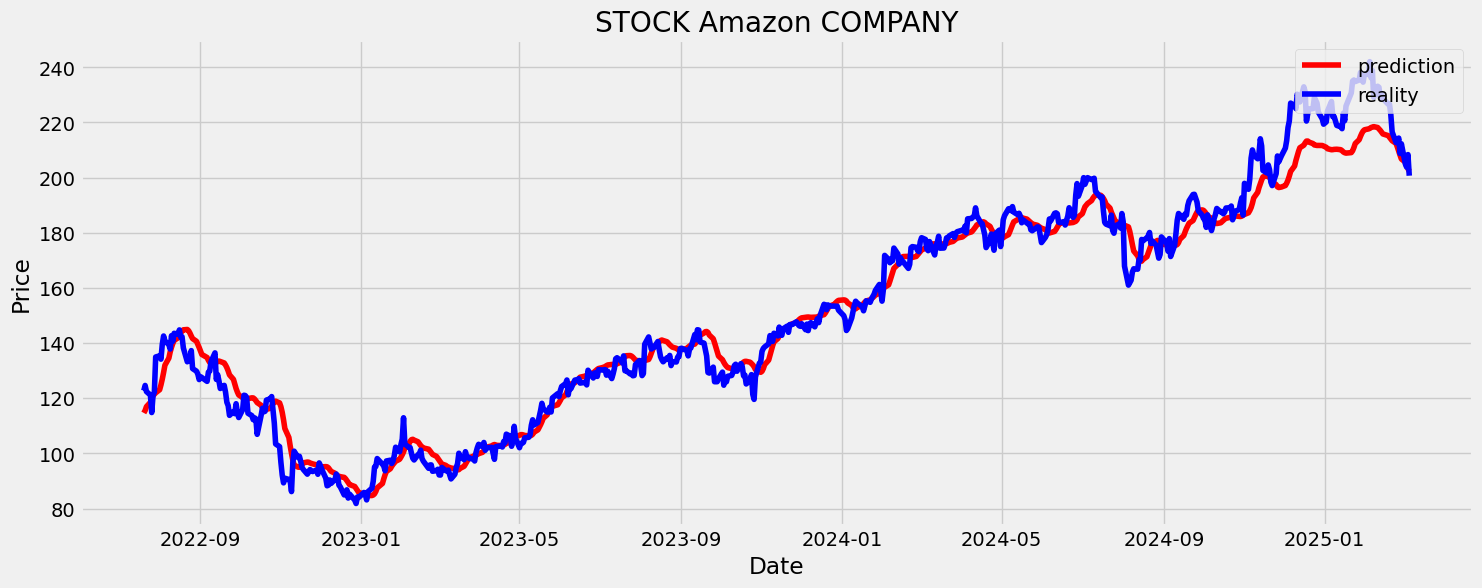

In [55]:
plt.figure(figsize=(16,6))
# đưa lên biểu đồ 
plt.plot(date_test[30:], test_1[30:], color='r')
plt.plot(date_test[30:], test_2[30:], color='b')
plt.title(f"STOCK {companyName} COMPANY")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(('prediction', 'reality'),loc='upper right')
plt.show()


In [57]:
test_output = model.predict(x_test) 
print("Evaluate on test data") 
results = model.evaluate(x_test, y_test, batch_size=128) 
print('\n')
print("test loss, test acc:", results,1-results)
print('Giá dư doán của ngày hôm qua: '+str(test_1[-1:]))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Evaluate on test data
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0018 


test loss, test acc: 0.0021050958894193172 0.9978949041105807
Giá dư doán của ngày hôm qua: [[202.30539]]
